In [1]:
import itertools
import math
import os
import gsd.hoomd
import hoomd
import numpy
import warnings
import fresnel
import IPython
import packaging.version 
import matplotlib
import random
import io 
import PIL 
import freud
import matplotlib.pyplot as plt

%matplotlib inline 
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

def render(snapshot):

    vertices = [
        (-1, -1),
        (1, -1),
        (1, 1),
        (-1, 1)
    ]

    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)

    geometry = fresnel.geometry.Polygon(
        scene, vertices = vertices, N=len(snapshot.particles.position)
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([100 / 255, 216 / 255, 230 / 255]), roughness=0.2
    )
    positions = numpy.array(snapshot.particles.position)[:, :2]
    geometry.position[:] = positions

    orientations = numpy.array(snapshot.particles.orientation)
    angles = 2 * numpy.arctan2(orientations[:, 3], orientations[:, 0])
    geometry.angle[:] = angles
    
    geometry.outline_width = 0.01

    fresnel.geometry.Box(scene, [L, L, 0.1, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(0, 0, 10), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [72]:
cpu = hoomd.device.CPU()

In [73]:
beta_P = 0.2 
filename0_2 = 'lattice_sq_v4_cmp.gsd'  

In [74]:
simulation = hoomd.Simulation(device=cpu, seed=17)
mc = hoomd.hpmc.integrate.ConvexPolygon()
mc.shape['Squares'] = dict(
    vertices=[
        (-1, -1),
        (1, -1),
        (1, 1),
        (-1, 1)
    ]
)
simulation.operations.integrator = mc

simulation.create_state_from_gsd(filename=filename0_2)

boxmc = hoomd.hpmc.update.BoxMC(
        trigger=hoomd.trigger.Periodic(100),
        betaP=beta_P
    )
boxmc.volume = dict(
    mode='standard',
    weight=1,
    delta=2
)
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.2,
    max_translation_move=1,
    max_rotation_move=0.5
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.5,
    max_move_size={'volume':100}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

trajectory_filename = f'trajectory_cmp_v5_bP_{beta_P:.1f}.gsd'
trajectory_path = os.path.join(os.getcwd(), trajectory_filename)

if os.path.exists(trajectory_path):
    os.remove(trajectory_path)

gsd_writer = hoomd.write.GSD(
    filename=trajectory_path, trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

boxmc.betaP = beta_P
    
volume_fractions = []
timesteps = []

print(f"Running simulation for beta_P = {beta_P}:")

for step in range(0, 2000000, 100):
    simulation.run(100)
    current_vf = (simulation.state.N_particles * 4) / simulation.state.box.volume
    volume_fractions.append(current_vf)
    timesteps.append(step)

std = numpy.std(volume_fractions[-(len(volume_fractions) // 4):])
avg = numpy.mean(volume_fractions[-(len(volume_fractions) // 4):])


print(f"  Stabilized Volume Fraction: {avg:.5f}, Std Dev: {std:.5f}")

gsd_writer.flush()

Running simulation for beta_P = 0.2:
  Stabilized Volume Fraction: 0.01234, Std Dev: 0.00027


In [75]:
filename0_4 = trajectory_filename
beta_P = 0.4

In [76]:
simulation = hoomd.Simulation(device=cpu, seed=17)
mc = hoomd.hpmc.integrate.ConvexPolygon()
mc.shape['Squares'] = dict(
    vertices=[
        (-1, -1),
        (1, -1),
        (1, 1),
        (-1, 1)
    ]
)
simulation.operations.integrator = mc

simulation.create_state_from_gsd(filename=filename0_4)

boxmc = hoomd.hpmc.update.BoxMC(
        trigger=hoomd.trigger.Periodic(100),
        betaP=beta_P
    )
boxmc.volume = dict(
    mode='standard',
    weight=1,
    delta=2
)
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.2,
    max_translation_move=1,
    max_rotation_move=0.5
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.5,
    max_move_size={'volume':100}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

trajectory_filename = f'trajectory_cmp_v5_bP_{beta_P:.1f}.gsd'
trajectory_path = os.path.join(os.getcwd(), trajectory_filename)

if os.path.exists(trajectory_path):
    os.remove(trajectory_path)

gsd_writer = hoomd.write.GSD(
    filename=trajectory_path, trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

boxmc.betaP = beta_P
    
volume_fractions = []
timesteps = []

print(f"Running simulation for beta_P = {beta_P}:")

for step in range(0, 2000000, 100):
    simulation.run(100)
    current_vf = (simulation.state.N_particles * 4) / simulation.state.box.volume
    volume_fractions.append(current_vf)
    timesteps.append(step)

std = numpy.std(volume_fractions[-(len(volume_fractions) // 4):])
avg = numpy.mean(volume_fractions[-(len(volume_fractions) // 4):])


print(f"  Stabilized Volume Fraction: {avg:.5f}, Std Dev: {std:.5f}")

gsd_writer.flush()

Running simulation for beta_P = 0.4:
  Stabilized Volume Fraction: 0.02372, Std Dev: 0.00152


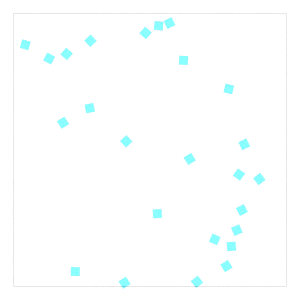

In [77]:
render(simulation.state.get_snapshot())

In [78]:
filename0_6 = trajectory_filename
beta_P = 0.6


In [79]:
simulation = hoomd.Simulation(device=cpu, seed=17)
mc = hoomd.hpmc.integrate.ConvexPolygon()
mc.shape['Squares'] = dict(
    vertices=[
        (-1, -1),
        (1, -1),
        (1, 1),
        (-1, 1)
    ]
)
simulation.operations.integrator = mc

simulation.create_state_from_gsd(filename=filename0_6)

boxmc = hoomd.hpmc.update.BoxMC(
        trigger=hoomd.trigger.Periodic(100),
        betaP=beta_P
    )
boxmc.volume = dict(
    mode='standard',
    weight=1,
    delta=2
)
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.2,
    max_translation_move=1,
    max_rotation_move=0.5
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.5,
    max_move_size={'volume':100}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

trajectory_filename = f'trajectory_cmp_v5_bP_{beta_P:.1f}.gsd'
trajectory_path = os.path.join(os.getcwd(), trajectory_filename)

if os.path.exists(trajectory_path):
    os.remove(trajectory_path)

gsd_writer = hoomd.write.GSD(
    filename=trajectory_path, trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

boxmc.betaP = beta_P
    
volume_fractions = []
timesteps = []

print(f"Running simulation for beta_P = {beta_P}:")

for step in range(0, 2000000, 100):
    simulation.run(100)
    current_vf = (simulation.state.N_particles * 4) / simulation.state.box.volume
    volume_fractions.append(current_vf)
    timesteps.append(step)

std = numpy.std(volume_fractions[-(len(volume_fractions) // 4):])
avg = numpy.mean(volume_fractions[-(len(volume_fractions) // 4):])


print(f"  Stabilized Volume Fraction: {avg:.5f}, Std Dev: {std:.5f}")

gsd_writer.flush()

Running simulation for beta_P = 0.6:
  Stabilized Volume Fraction: 0.53797, Std Dev: 0.02136


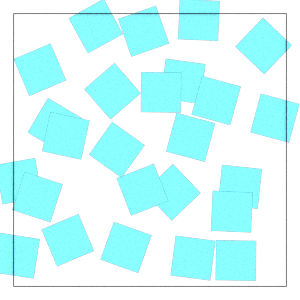

In [80]:
render(simulation.state.get_snapshot())

In [81]:
filename0_8 = trajectory_filename
beta_P = 0.8

In [82]:
simulation = hoomd.Simulation(device=cpu, seed=17)
mc = hoomd.hpmc.integrate.ConvexPolygon()
mc.shape['Squares'] = dict(
    vertices=[
        (-1, -1),
        (1, -1),
        (1, 1),
        (-1, 1)
    ]
)
simulation.operations.integrator = mc

simulation.create_state_from_gsd(filename=filename0_8)

boxmc = hoomd.hpmc.update.BoxMC(
        trigger=hoomd.trigger.Periodic(100),
        betaP=beta_P
    )
boxmc.volume = dict(
    mode='standard',
    weight=1,
    delta=2
)
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.2,
    max_translation_move=1,
    max_rotation_move=0.5
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.5,
    max_move_size={'volume':100}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

trajectory_filename = f'trajectory_cmp_v5_bP_{beta_P:.1f}.gsd'
trajectory_path = os.path.join(os.getcwd(), trajectory_filename)

if os.path.exists(trajectory_path):
    os.remove(trajectory_path)

gsd_writer = hoomd.write.GSD(
    filename=trajectory_path, trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

boxmc.betaP = beta_P
    
volume_fractions = []
timesteps = []

print(f"Running simulation for beta_P = {beta_P}:")

for step in range(0, 2000000, 100):
    simulation.run(100)
    current_vf = (simulation.state.N_particles * 4) / simulation.state.box.volume
    volume_fractions.append(current_vf)
    timesteps.append(step)

std = numpy.std(volume_fractions[-(len(volume_fractions) // 4):])
avg = numpy.mean(volume_fractions[-(len(volume_fractions) // 4):])


print(f"  Stabilized Volume Fraction: {avg:.5f}, Std Dev: {std:.5f}")

gsd_writer.flush()

Running simulation for beta_P = 0.8:
  Stabilized Volume Fraction: 0.59251, Std Dev: 0.02772


In [83]:
filename0_10 = trajectory_filename
beta_P = 1.0


In [84]:
simulation = hoomd.Simulation(device=cpu, seed=17)
mc = hoomd.hpmc.integrate.ConvexPolygon()
mc.shape['Squares'] = dict(
    vertices=[
        (-1, -1),
        (1, -1),
        (1, 1),
        (-1, 1)
    ]
)
simulation.operations.integrator = mc

simulation.create_state_from_gsd(filename=filename0_10)

boxmc = hoomd.hpmc.update.BoxMC(
        trigger=hoomd.trigger.Periodic(100),
        betaP=beta_P
    )
boxmc.volume = dict(
    mode='standard',
    weight=1,
    delta=2
)
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.2,
    max_translation_move=1,
    max_rotation_move=0.5
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.5,
    max_move_size={'volume':100}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

trajectory_filename = f'trajectory_cmp_v5_bP_{beta_P:.1f}.gsd'
trajectory_path = os.path.join(os.getcwd(), trajectory_filename)

if os.path.exists(trajectory_path):
    os.remove(trajectory_path)

gsd_writer = hoomd.write.GSD(
    filename=trajectory_path, trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

boxmc.betaP = beta_P
    
volume_fractions = []
timesteps = []

print(f"Running simulation for beta_P = {beta_P}:")

for step in range(0, 2000000, 100):
    simulation.run(100)
    current_vf = (simulation.state.N_particles * 4) / simulation.state.box.volume
    volume_fractions.append(current_vf)
    timesteps.append(step)

std = numpy.std(volume_fractions[-(len(volume_fractions) // 4):])
avg = numpy.mean(volume_fractions[-(len(volume_fractions) // 4):])


print(f"  Stabilized Volume Fraction: {avg:.5f}, Std Dev: {std:.5f}")

gsd_writer.flush()

Running simulation for beta_P = 1.0:
  Stabilized Volume Fraction: 0.64755, Std Dev: 0.02645


In [85]:
filename0_12 = trajectory_filename
beta_P = 1.2


simulation = hoomd.Simulation(device=cpu, seed=17)
mc = hoomd.hpmc.integrate.ConvexPolygon()
mc.shape['Squares'] = dict(
    vertices=[
        (-1, -1),
        (1, -1),
        (1, 1),
        (-1, 1)
    ]
)
simulation.operations.integrator = mc

simulation.create_state_from_gsd(filename=filename0_12)

boxmc = hoomd.hpmc.update.BoxMC(
        trigger=hoomd.trigger.Periodic(100),
        betaP=beta_P
    )
boxmc.volume = dict(
    mode='standard',
    weight=1,
    delta=2
)
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.2,
    max_translation_move=1,
    max_rotation_move=0.5
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.5,
    max_move_size={'volume':100}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

trajectory_filename = f'trajectory_cmp_v5_bP_{beta_P:.1f}.gsd'
trajectory_path = os.path.join(os.getcwd(), trajectory_filename)

if os.path.exists(trajectory_path):
    os.remove(trajectory_path)

gsd_writer = hoomd.write.GSD(
    filename=trajectory_path, trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

boxmc.betaP = beta_P
    
volume_fractions = []
timesteps = []

print(f"Running simulation for beta_P = {beta_P}:")

for step in range(0, 2000000, 100):
    simulation.run(100)
    current_vf = (simulation.state.N_particles * 4) / simulation.state.box.volume
    volume_fractions.append(current_vf)
    timesteps.append(step)

std = numpy.std(volume_fractions[-(len(volume_fractions) // 4):])
avg = numpy.mean(volume_fractions[-(len(volume_fractions) // 4):])


print(f"  Stabilized Volume Fraction: {avg:.5f}, Std Dev: {std:.5f}")

gsd_writer.flush()

Running simulation for beta_P = 1.2:
  Stabilized Volume Fraction: 0.68650, Std Dev: 0.02098


In [86]:
filename0_14 = trajectory_filename
beta_P = 1.4


simulation = hoomd.Simulation(device=cpu, seed=17)
mc = hoomd.hpmc.integrate.ConvexPolygon()
mc.shape['Squares'] = dict(
    vertices=[
        (-1, -1),
        (1, -1),
        (1, 1),
        (-1, 1)
    ]
)
simulation.operations.integrator = mc

simulation.create_state_from_gsd(filename=filename0_14)

boxmc = hoomd.hpmc.update.BoxMC(
        trigger=hoomd.trigger.Periodic(100),
        betaP=beta_P
    )
boxmc.volume = dict(
    mode='standard',
    weight=1,
    delta=2
)
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.2,
    max_translation_move=1,
    max_rotation_move=0.5
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.5,
    max_move_size={'volume':100}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

trajectory_filename = f'trajectory_cmp_v5_bP_{beta_P:.1f}.gsd'
trajectory_path = os.path.join(os.getcwd(), trajectory_filename)

if os.path.exists(trajectory_path):
    os.remove(trajectory_path)

gsd_writer = hoomd.write.GSD(
    filename=trajectory_path, trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

boxmc.betaP = beta_P
    
volume_fractions = []
timesteps = []

print(f"Running simulation for beta_P = {beta_P}:")

for step in range(0, 2000000, 100):
    simulation.run(100)
    current_vf = (simulation.state.N_particles * 4) / simulation.state.box.volume
    volume_fractions.append(current_vf)
    timesteps.append(step)

std = numpy.std(volume_fractions[-(len(volume_fractions) // 4):])
avg = numpy.mean(volume_fractions[-(len(volume_fractions) // 4):])


print(f"  Stabilized Volume Fraction: {avg:.5f}, Std Dev: {std:.5f}")

gsd_writer.flush()

Running simulation for beta_P = 1.4:
  Stabilized Volume Fraction: 0.72110, Std Dev: 0.01751


In [87]:
filename0_16 = trajectory_filename
beta_P = 1.6


simulation = hoomd.Simulation(device=cpu, seed=17)
mc = hoomd.hpmc.integrate.ConvexPolygon()
mc.shape['Squares'] = dict(
    vertices=[
        (-1, -1),
        (1, -1),
        (1, 1),
        (-1, 1)
    ]
)
simulation.operations.integrator = mc

simulation.create_state_from_gsd(filename=filename0_16)

boxmc = hoomd.hpmc.update.BoxMC(
        trigger=hoomd.trigger.Periodic(100),
        betaP=beta_P
    )
boxmc.volume = dict(
    mode='standard',
    weight=1,
    delta=2
)
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.2,
    max_translation_move=1,
    max_rotation_move=0.5
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.5,
    max_move_size={'volume':100}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

trajectory_filename = f'trajectory_cmp_v5_bP_{beta_P:.1f}.gsd'
trajectory_path = os.path.join(os.getcwd(), trajectory_filename)

if os.path.exists(trajectory_path):
    os.remove(trajectory_path)

gsd_writer = hoomd.write.GSD(
    filename=trajectory_path, trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

boxmc.betaP = beta_P
    
volume_fractions = []
timesteps = []

print(f"Running simulation for beta_P = {beta_P}:")

for step in range(0, 2000000, 100):
    simulation.run(100)
    current_vf = (simulation.state.N_particles * 4) / simulation.state.box.volume
    volume_fractions.append(current_vf)
    timesteps.append(step)

std = numpy.std(volume_fractions[-(len(volume_fractions) // 4):])
avg = numpy.mean(volume_fractions[-(len(volume_fractions) // 4):])


print(f"  Stabilized Volume Fraction: {avg:.5f}, Std Dev: {std:.5f}")

gsd_writer.flush()

Running simulation for beta_P = 1.6:
  Stabilized Volume Fraction: 0.74379, Std Dev: 0.02567


In [88]:
filename0_18 = trajectory_filename
beta_P = 1.8


simulation = hoomd.Simulation(device=cpu, seed=17)
mc = hoomd.hpmc.integrate.ConvexPolygon()
mc.shape['Squares'] = dict(
    vertices=[
        (-1, -1),
        (1, -1),
        (1, 1),
        (-1, 1)
    ]
)
simulation.operations.integrator = mc

simulation.create_state_from_gsd(filename=filename0_18)

boxmc = hoomd.hpmc.update.BoxMC(
        trigger=hoomd.trigger.Periodic(100),
        betaP=beta_P
    )
boxmc.volume = dict(
    mode='standard',
    weight=1,
    delta=2
)
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.2,
    max_translation_move=1,
    max_rotation_move=0.5
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.5,
    max_move_size={'volume':100}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

trajectory_filename = f'trajectory_cmp_v5_bP_{beta_P:.1f}.gsd'
trajectory_path = os.path.join(os.getcwd(), trajectory_filename)

if os.path.exists(trajectory_path):
    os.remove(trajectory_path)

gsd_writer = hoomd.write.GSD(
    filename=trajectory_path, trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

boxmc.betaP = beta_P
    
volume_fractions = []
timesteps = []

print(f"Running simulation for beta_P = {beta_P}:")

for step in range(0, 2000000, 100):
    simulation.run(100)
    current_vf = (simulation.state.N_particles * 4) / simulation.state.box.volume
    volume_fractions.append(current_vf)
    timesteps.append(step)

std = numpy.std(volume_fractions[-(len(volume_fractions) // 4):])
avg = numpy.mean(volume_fractions[-(len(volume_fractions) // 4):])


print(f"  Stabilized Volume Fraction: {avg:.5f}, Std Dev: {std:.5f}")

gsd_writer.flush()

Running simulation for beta_P = 1.8:
  Stabilized Volume Fraction: 0.75514, Std Dev: 0.02060


In [89]:
filename0_20 = trajectory_filename
beta_P = 2.0


simulation = hoomd.Simulation(device=cpu, seed=17)
mc = hoomd.hpmc.integrate.ConvexPolygon()
mc.shape['Squares'] = dict(
    vertices=[
        (-1, -1),
        (1, -1),
        (1, 1),
        (-1, 1)
    ]
)
simulation.operations.integrator = mc

simulation.create_state_from_gsd(filename=filename0_20)

boxmc = hoomd.hpmc.update.BoxMC(
        trigger=hoomd.trigger.Periodic(100),
        betaP=beta_P
    )
boxmc.volume = dict(
    mode='standard',
    weight=1,
    delta=2
)
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.2,
    max_translation_move=1,
    max_rotation_move=0.5
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.5,
    max_move_size={'volume':100}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

trajectory_filename = f'trajectory_cmp_v5_bP_{beta_P:.1f}.gsd'
trajectory_path = os.path.join(os.getcwd(), trajectory_filename)

if os.path.exists(trajectory_path):
    os.remove(trajectory_path)

gsd_writer = hoomd.write.GSD(
    filename=trajectory_path, trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

boxmc.betaP = beta_P
    
volume_fractions = []
timesteps = []

print(f"Running simulation for beta_P = {beta_P}:")

for step in range(0, 2000000, 100):
    simulation.run(100)
    current_vf = (simulation.state.N_particles * 4) / simulation.state.box.volume
    volume_fractions.append(current_vf)
    timesteps.append(step)

std = numpy.std(volume_fractions[-(len(volume_fractions) // 4):])
avg = numpy.mean(volume_fractions[-(len(volume_fractions) // 4):])


print(f"  Stabilized Volume Fraction: {avg:.5f}, Std Dev: {std:.5f}")

gsd_writer.flush()

Running simulation for beta_P = 2.0:
  Stabilized Volume Fraction: 0.77962, Std Dev: 0.01640


In [90]:
filename0_22 = trajectory_filename
beta_P = 2.2


simulation = hoomd.Simulation(device=cpu, seed=17)
mc = hoomd.hpmc.integrate.ConvexPolygon()
mc.shape['Squares'] = dict(
    vertices=[
        (-1, -1),
        (1, -1),
        (1, 1),
        (-1, 1)
    ]
)
simulation.operations.integrator = mc

simulation.create_state_from_gsd(filename=filename0_22)

boxmc = hoomd.hpmc.update.BoxMC(
        trigger=hoomd.trigger.Periodic(100),
        betaP=beta_P
    )
boxmc.volume = dict(
    mode='standard',
    weight=1,
    delta=2
)
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.2,
    max_translation_move=1,
    max_rotation_move=0.5
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.5,
    max_move_size={'volume':100}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

trajectory_filename = f'trajectory_cmp_v5_bP_{beta_P:.1f}.gsd'
trajectory_path = os.path.join(os.getcwd(), trajectory_filename)

if os.path.exists(trajectory_path):
    os.remove(trajectory_path)

gsd_writer = hoomd.write.GSD(
    filename=trajectory_path, trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

boxmc.betaP = beta_P
    
volume_fractions = []
timesteps = []

print(f"Running simulation for beta_P = {beta_P}:")

for step in range(0, 2000000, 100):
    simulation.run(100)
    current_vf = (simulation.state.N_particles * 4) / simulation.state.box.volume
    volume_fractions.append(current_vf)
    timesteps.append(step)

std = numpy.std(volume_fractions[-(len(volume_fractions) // 4):])
avg = numpy.mean(volume_fractions[-(len(volume_fractions) // 4):])


print(f"  Stabilized Volume Fraction: {avg:.5f}, Std Dev: {std:.5f}")

gsd_writer.flush()

Running simulation for beta_P = 2.2:
  Stabilized Volume Fraction: 0.78739, Std Dev: 0.02373


In [91]:
filename0_24 = trajectory_filename
beta_P = 2.4


simulation = hoomd.Simulation(device=cpu, seed=17)
mc = hoomd.hpmc.integrate.ConvexPolygon()
mc.shape['Squares'] = dict(
    vertices=[
        (-1, -1),
        (1, -1),
        (1, 1),
        (-1, 1)
    ]
)
simulation.operations.integrator = mc

simulation.create_state_from_gsd(filename=filename0_24)

boxmc = hoomd.hpmc.update.BoxMC(
        trigger=hoomd.trigger.Periodic(100),
        betaP=beta_P
    )
boxmc.volume = dict(
    mode='standard',
    weight=1,
    delta=2
)
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.2,
    max_translation_move=1,
    max_rotation_move=0.5
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.5,
    max_move_size={'volume':100}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

trajectory_filename = f'trajectory_cmp_v5_bP_{beta_P:.1f}.gsd'
trajectory_path = os.path.join(os.getcwd(), trajectory_filename)

if os.path.exists(trajectory_path):
    os.remove(trajectory_path)

gsd_writer = hoomd.write.GSD(
    filename=trajectory_path, trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

boxmc.betaP = beta_P
    
volume_fractions = []
timesteps = []

print(f"Running simulation for beta_P = {beta_P}:")

for step in range(0, 2000000, 100):
    simulation.run(100)
    current_vf = (simulation.state.N_particles * 4) / simulation.state.box.volume
    volume_fractions.append(current_vf)
    timesteps.append(step)

std = numpy.std(volume_fractions[-(len(volume_fractions) // 4):])
avg = numpy.mean(volume_fractions[-(len(volume_fractions) // 4):])


print(f"  Stabilized Volume Fraction: {avg:.5f}, Std Dev: {std:.5f}")

gsd_writer.flush()

Running simulation for beta_P = 2.4:
  Stabilized Volume Fraction: 0.80570, Std Dev: 0.02002


In [92]:
filename0_26 = trajectory_filename
beta_P = 2.6


simulation = hoomd.Simulation(device=cpu, seed=17)
mc = hoomd.hpmc.integrate.ConvexPolygon()
mc.shape['Squares'] = dict(
    vertices=[
        (-1, -1),
        (1, -1),
        (1, 1),
        (-1, 1)
    ]
)
simulation.operations.integrator = mc

simulation.create_state_from_gsd(filename=filename0_26)

boxmc = hoomd.hpmc.update.BoxMC(
        trigger=hoomd.trigger.Periodic(100),
        betaP=beta_P
    )
boxmc.volume = dict(
    mode='standard',
    weight=1,
    delta=2
)
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.2,
    max_translation_move=1,
    max_rotation_move=0.5
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.5,
    max_move_size={'volume':100}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

trajectory_filename = f'trajectory_cmp_v5_bP_{beta_P:.1f}.gsd'
trajectory_path = os.path.join(os.getcwd(), trajectory_filename)

if os.path.exists(trajectory_path):
    os.remove(trajectory_path)

gsd_writer = hoomd.write.GSD(
    filename=trajectory_path, trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

boxmc.betaP = beta_P
    
volume_fractions = []
timesteps = []

print(f"Running simulation for beta_P = {beta_P}:")

for step in range(0, 2000000, 100):
    simulation.run(100)
    current_vf = (simulation.state.N_particles * 4) / simulation.state.box.volume
    volume_fractions.append(current_vf)
    timesteps.append(step)

std = numpy.std(volume_fractions[-(len(volume_fractions) // 4):])
avg = numpy.mean(volume_fractions[-(len(volume_fractions) // 4):])


print(f"  Stabilized Volume Fraction: {avg:.5f}, Std Dev: {std:.5f}")

gsd_writer.flush()

Running simulation for beta_P = 2.6:
  Stabilized Volume Fraction: 0.82110, Std Dev: 0.01778


In [93]:
filename0_26 = trajectory_filename
beta_P = 2.8


simulation = hoomd.Simulation(device=cpu, seed=17)
mc = hoomd.hpmc.integrate.ConvexPolygon()
mc.shape['Squares'] = dict(
    vertices=[
        (-1, -1),
        (1, -1),
        (1, 1),
        (-1, 1)
    ]
)
simulation.operations.integrator = mc

simulation.create_state_from_gsd(filename=filename0_26)

boxmc = hoomd.hpmc.update.BoxMC(
        trigger=hoomd.trigger.Periodic(100),
        betaP=beta_P
    )
boxmc.volume = dict(
    mode='standard',
    weight=1,
    delta=2
)
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.2,
    max_translation_move=1,
    max_rotation_move=0.5
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.5,
    max_move_size={'volume':100}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

trajectory_filename = f'trajectory_cmp_v5_bP_{beta_P:.1f}.gsd'
trajectory_path = os.path.join(os.getcwd(), trajectory_filename)

if os.path.exists(trajectory_path):
    os.remove(trajectory_path)

gsd_writer = hoomd.write.GSD(
    filename=trajectory_path, trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

boxmc.betaP = beta_P
    
volume_fractions = []
timesteps = []

print(f"Running simulation for beta_P = {beta_P}:")

for step in range(0, 2000000, 100):
    simulation.run(100)
    current_vf = (simulation.state.N_particles * 4) / simulation.state.box.volume
    volume_fractions.append(current_vf)
    timesteps.append(step)

std = numpy.std(volume_fractions[-(len(volume_fractions) // 4):])
avg = numpy.mean(volume_fractions[-(len(volume_fractions) // 4):])


print(f"  Stabilized Volume Fraction: {avg:.5f}, Std Dev: {std:.5f}")

gsd_writer.flush()

Running simulation for beta_P = 2.8:
  Stabilized Volume Fraction: 0.85129, Std Dev: 0.01588


In [95]:
filename0_26 = trajectory_filename
beta_P = 3.0


simulation = hoomd.Simulation(device=cpu, seed=17)
mc = hoomd.hpmc.integrate.ConvexPolygon()
mc.shape['Squares'] = dict(
    vertices=[
        (-1, -1),
        (1, -1),
        (1, 1),
        (-1, 1)
    ]
)
simulation.operations.integrator = mc

simulation.create_state_from_gsd(filename=filename0_26)

boxmc = hoomd.hpmc.update.BoxMC(
        trigger=hoomd.trigger.Periodic(100),
        betaP=beta_P
    )
boxmc.volume = dict(
    mode='standard',
    weight=1,
    delta=2
)
simulation.operations.updaters.append(boxmc)

tune1 = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=10,
    moves=['d', 'a'],
    target=0.2,
    max_translation_move=1,
    max_rotation_move=0.5
)
tune2 = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(
    trigger=100,
    boxmc=boxmc,
    moves=['volume'],
    target=0.5,
    max_move_size={'volume':100}
)
simulation.operations.tuners.append(tune1)
simulation.operations.tuners.append(tune2)

trajectory_filename = f'trajectory_cmp_v5_bP_{beta_P:.1f}.gsd'
trajectory_path = os.path.join(os.getcwd(), trajectory_filename)

if os.path.exists(trajectory_path):
    os.remove(trajectory_path)

gsd_writer = hoomd.write.GSD(
    filename=trajectory_path, trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

boxmc.betaP = beta_P
    
volume_fractions = []
timesteps = []

print(f"Running simulation for beta_P = {beta_P}:")

for step in range(0, 2000000, 100):
    simulation.run(100)
    current_vf = (simulation.state.N_particles * 4) / simulation.state.box.volume
    volume_fractions.append(current_vf)
    timesteps.append(step)

std = numpy.std(volume_fractions[-(len(volume_fractions) // 4):])
avg = numpy.mean(volume_fractions[-(len(volume_fractions) // 4):])


print(f"  Stabilized Volume Fraction: {avg:.5f}, Std Dev: {std:.5f}")

gsd_writer.flush()

Running simulation for beta_P = 3.0:
  Stabilized Volume Fraction: 0.85579, Std Dev: 0.01455


In [96]:
simulation.timestep

30000000